In [1197]:
import math
import pandas as pd
import networkx as nx
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.colors as pltcol
pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [2]:
#Erzeuge Knoten, Kanten aus Datei mit Metadaten
def get_entity_rel(meta, KG_entities, keyword_list_paper, keyword_list_con):
    #Erstellung initial fester Überknoten
    KG_entities.add_node("Paper", color=0.9, typ='class')
    KG_entities.add_node("Autor", color=2, typ='class')
    KG_entities.add_node("Konferenz", color=3, typ='class')
    KG_entities.add_node("Themengebiet paper", color=10, typ='class')
    KG_entities.add_node("Themengebiet Konferenz", color=5, typ='class')
    
    for i in range(len(meta)):
        
        cur_authors =  meta['Authors'][i].split(',')
        #Knotenerstellung aller Titel und Erstellungsdatum als Attribut und typ Titel
        KG_entities.add_node(meta['Titles'][i], date=meta['Date'][i], color=0.8, typ='Titel')
        #Knotenerstellung aller Konferenzen mit Attribut typ Konferenz
        KG_entities.add_node(meta['Conference'][i], color=3.2, typ='Konferenz')
        #Kantenerstellung zwischen Überklasse paper und allen Titeln mit Attribut label ist
        KG_entities.add_edge(meta['Titles'][i], 'Paper', label='ist')
        #Beziehung zwischen Überklasse Konferenz und allen Konferenztiteln mit Attribut label ist
        KG_entities.add_edge(meta['Conference'][i], 'Konferenz', label='ist')
        #Beziehung zwischen Titel und Konferenz mit Attribut label ist Teil von
        KG_entities.add_edge(meta['Titles'][i], meta['Conference'][i], label='ist Teil von')
        #Erstellung Knoten für Autoren und deren Verbindungen
        for author in cur_authors:
            author = author.strip()
            #Knotenerstellung aller Autoren mit Attribut typ Autor
            KG_entities.add_node(author, color=2, typ='Autor')
            #Beziehung zwischen Autoren und Titel mit Attribut label hat verfasst
            KG_entities.add_edge(author, meta['Titles'][i], label='hat verfasst')
            #Beziehung zwischen Autoren Überknoten Autor mit Attribut label ist
            KG_entities.add_edge(author, 'Autor', label='ist')
        #Themen paper
        for j in range(len(keyword_list_paper['keywords'])):
            #Festlegung mindest Relevanz
            if keyword_list_paper['relevance'][j] > 0.4:
                #Knotenerstellung aller keywords mit Attribut typ Thema paper
                KG_entities.add_node(keyword_list_paper['keywords'][j], color=9.5, typ='Thema paper')
                #Beziehung zwischen keywords und Überknoten Themengebiet paper mit Attribut label ist
                KG_entities.add_edge(keyword_list_paper['keywords'][j], 'Themengebiet paper', label='ist')
                if meta['Titles'][i] == keyword_list_paper['paper'][j]:
                    #Beziehung zwischen Titeln und keywords mit Attribut label handelt von
                    KG_entities.add_edge(meta['Titles'][i], keyword_list_paper['keywords'][j], label='handelt von')
                        
        #Themen Konferenzen     
        for j in range(len(keyword_list_con['keywords'])):
            #Festlegung mindest Relevanz
            if keyword_list_con['relevance'][j] > 0.44:
                #Knotenerstellung aller keywords mit Attribut typ Thema Konferenz
                KG_entities.add_node(keyword_list_con['keywords'][j], color=4.5, typ='Thema Konferenz')
                #Beziehung zwischen keywords und Überknoten Themengebiet Konferenz mit Attribut label ist
                KG_entities.add_edge(keyword_list_con['keywords'][j], 'Themengebiet Konferenz', label='ist')
                if meta['Conference'][i] == keyword_list_con['conference'][j]:
                    #Beziehung zwischen Konferenzen und keywords mit Attribut label thematisiert
                    KG_entities.add_edge(meta['Conference'][i], keyword_list_con['keywords'][j], label="thematisiert")

    return KG_entities

In [3]:
#Farbschema des Graphen
def kg_colors(graph, vmin=0, vmax=7):
    cnorm = pltcol.Normalize(vmin=vmin, vmax=vmax)
    cpick = cm.ScalarMappable(norm=cnorm, cmap='turbo')
    cpick.set_array([])
    val_map = {}
    for k, v in nx.get_node_attributes(graph, 'color').items():
        val_map[k] = cpick.to_rgba(v)
    colors = []
    for node in graph.nodes():
        colors.append(val_map[node])
    return colors

In [1195]:
def query_graph(G_KG,n,class_result,visited,selects={}): 
    selects_tmp={}
    if n not in visited: #falls aktueller Knoten noch nicht in visited
        visited.add(n)  #füge Knoten zu visited hinzu
        if not G_KG.nodes[n]['typ'] == 'class': #falls Knoten kein Überknoten ist
            cur_node_type = G_KG.nodes[n]['typ'] #Zwischenspeichern des aktuellen Knoten typs
            
            if n not in selects_tmp: #falls aktueller Knoten noch nicht in aktuellem dict
                selects_tmp[cur_node_type] = n #füge hinzu
            else:
                if not isinstance(selects_tmp[cur_node_type], list): #falls values von aktuellem Knoten zum aktuellen key keine Liste
                    selects_tmp[cur_node_type] = [selects_tmp[n]] #mache Liste draus und füge Knoten hinzu zum aktuellen key
                selects_tmp[cur_node_type].append(n) #ansonsten appende
                
            if selects and not class_result == '': # Check ob dictionary nicht leer und nach einem bestimmten Ergebnissen gesucht werden soll
                selects = dict_korr(G_KG,selects,selects_tmp,class_result) #Aufruf dict_korr mit class_result
            if selects and class_result == '': # Check ob dictionary nicht leer und nach keinem bestimmten Ergebnissen gesucht werden soll
                selects = dict_korr_all(G_KG,selects,selects_tmp) #Aufruf dict_korr_all ohne class_result
            if not selects: #falls selects noch leer
                selects = selects_tmp #selects_tmp in selects
                
        for neighbour in nx.all_neighbors(G_KG, n): #iteration durch Nachbarn vom aktuellen Knoten
        
            if G_KG.nodes[neighbour]['typ'] == 'class' or neighbour in visited: #falls Knoten Überklasse ist oder schon in visisted überspringe
                continue
            else:
                selects = query_graph(G_KG,neighbour,class_result,visited,selects) #ansonsten rekursiver Aufruf von query_graph mit Nachbarknoten
    return selects

In [1178]:
#mergen der dictionaries (mehrere values für einen key, jedoch keine doppelten Werte)
def merge_dictionary(selects, selects_tmp):   
    dict_3 = {**selects_tmp,**selects} #erstellt neues dictionary aus merge von selects_tmp und selects (überschreibt sich)
    for key, value in selects_tmp.items(): #Iteration über key:value pairs
            if key in selects and key in selects_tmp: #wenn key in beiden dictionaries
                if (value not in selects.values()): #wenn value noch nicht in Ergebnis dictionary
                    if not isinstance(dict_3[key], list): #Check ob Typ von value von key gleich Liste
                        dict_3[key] = [dict_3[key]] #wenn nicht mach eine Liste draus
                    dict_3[key].append(value) #append des values
    
    dict_3 = {**selects,**dict_3} #erneutes mergen (nur um Reihenfolge der key:value pairs zu ändern)
    return dict_3              

In [1193]:
#Korrektur der zu mergenden dictionaries, je nach Angabe was gefunden werden soll (Angabe class_result)
def dict_korr(G_KG,selects, selects_tmp, class_result):
    selects_tmp_keys = list(selects_tmp.keys())#Liste der keys von selects_tmp
    selects_values = list(selects.values())#Liste der values von selects
    selects_tmp_values = list(selects_tmp.values())#Liste der values von selects_tmp
    dict_tmp = {'Autor':[]}
    
    #falls Titel gesucht werden, ein Titel reinkommt und auch eine Kante zu dem gesuchten keyword hat
    if ((class_result == 'Titel' and selects_tmp_keys[0] == class_result and G_KG.has_edge(selects_tmp_values[0], selects_values[0])) or 
        # oder falls Autoren gesucht werden, ein Titel reinkommt und eine Kante zu dem gesuchten keyword hat
        (class_result == 'Autor' and selects_tmp_keys[0] == 'Titel' and G_KG.has_edge(selects_tmp_values[0], selects_values[0]))):
        dict_3 = merge_dictionary(selects, selects_tmp) #Aufruf merge dictionary Funktion
        
        #Falls Titel gesucht werden, gib das entstandene dict3 zurück
        if class_result == 'Titel': 
            return dict_3
        #Falls Autoren gesucht werden
        if class_result == 'Autor':
            values = dict_3.get('Titel')#holen des values vom key Titel aus entstandenen dict3(Liste der enthaltenen Titel) (enthält auch None)

            if not values == None: #Falls value existiert
                for neighbour in nx.all_neighbors(G_KG, values): #Iteration über alle Nachbarn des aktuellen value
                    if G_KG.nodes[neighbour]['typ'] == 'Autor': #falls Nachbar ein Autor ist
                        if neighbour not in dict_tmp.values(): #Falls Nachbar noch nicht enthalten
                            dict_tmp['Autor'].append(neighbour) #Anhängen des Autoren zum key Autor (baut dict_tmp)
                if dict_tmp.values() not in selects.values(): #Falls der Autor aus dict_tmp noch nicht in selects, rufe merge Funktion auf
                    dict_3 = merge_dictionary(selects, dict_tmp)
                return dict_3 #Rückgabe des neuen dicts
    #Falls Konferenzen gesucht werden, eine Konferenz reinkommt und eine Kante zum eingegebenen keywords hat
    if class_result == 'Konferenz' and selects_tmp_keys[0] == class_result and G_KG.has_edge(selects_tmp_values[0], selects_values[0]):
        dict_3 = merge_dictionary(selects, selects_tmp) #Aufruf merge Funktion
        return dict_3 #Rückgabe neues dict

    return selects #Falls keine Abfrage greift, gebe wieder selects zurück ohne Veränderung

In [1196]:
#Korrektur der zu mergenden dictionaries, wenn keine Angabe was gefunden werden soll (gibt alles aus)
def dict_korr_all(G_KG,selects, selects_tmp):

    flag = False
    selects_keys = list(selects.keys())
    selects_tmp_keys = list(selects_tmp.keys())
    selects_values = list(selects.values())
    selects_tmp_values = list(selects_tmp.values())

    #Einschränkung Titel Suche (Suchbegriff ist Titel)
    if selects_keys[0] == 'Titel':
        if selects_tmp_keys[0] == 'Titel': 
            return selects #mache nichts, da Titel die Ersteingabe war und nicht weitere Titel gefunden werden sollen
        if selects_tmp_keys[0] == 'Autor' and not G_KG.has_edge(selects_tmp_values[0],selects_values[0]): #es wird ein Autor oder Konferenz reingegeben
            return selects #mache nichts, da nicht noch eine Konferenz oder Autoren anderer Titel rauskommen sollen (wegen Reihenfolge wie Knoten durchlaufen werden)
        if selects_tmp_keys[0] == 'Konferenz' and not G_KG.has_edge(selects_values[0], selects_tmp_values[0]):
            return selects 
        if selects_tmp_keys[0] == 'Thema paper' and not G_KG.has_edge(selects_values[0], selects_tmp_values[0]): #nur Themen, die eine Kante zum Ersteingegebenen Titel haben
            return selects #mache nichts
        if selects_tmp_keys[0] =='Thema Konferenz': #Falls Konferenz Thema reinkommt
            print(selects_tmp_values[0])
            for k,v in selects.items(): #iteration über key:value pairs von selects
                if k == 'Konferenz' and G_KG.has_edge(v,selects_tmp_values[0]): #falls key Konferenz ist und eine Kante zum Thema Konferenz hat
                    dict_3 = merge_dictionary(selects, selects_tmp) #nimm Konferenz Thema auf
                    return dict_3
                else:
                    flag = True

    #Einschränkung Konferenz Suche(Suchbegriff ist Konferenz)
    if selects_keys[0] == 'Konferenz':
        #keine Aufnahme von paper Themen, Autoren oder Konferenzen (nur Titel und Konferenzthemen)
        if selects_tmp_keys[0] == 'Thema paper' or selects_tmp_keys[0] == 'Autor' or selects_tmp_keys[0] == 'Konferenz':
            return selects
        
    #Einschränkung Thema Paper Suche(Suchbegriff ist paper Thema)
    if selects_keys[0] == 'Thema paper':
        if selects_tmp_keys[0] == 'Thema paper' or selects_tmp_keys[0] == 'Thema Konferenz': #keine Aufnahme von anderen paper/Konferenz Themen
            return selects
        if selects_tmp_keys[0] == 'Titel' and not G_KG.has_edge(selects_tmp_values[0], selects_values[0]): #Nur Aufnahme von Titeln, falls Kante zu Thema paper existiert
            return selects
        if selects_tmp_keys[0] =='Autor': #falls Autor reinkommt
            for k,v in selects.items():
                if k == 'Titel' and G_KG.has_edge(selects_tmp_values[0], v): #falls key ein Titel ist und der Titel eine Kante zum Autor hat Aufnahme
                    dict_3 = merge_dictionary(selects, selects_tmp)
                    return dict_3
                else:
                    flag = True
                    
    #Einschränkung Thema Konferenz Suche(der Knoten, der zuerst gefunden wird ist ein Konferenz Thema)
    if selects_keys[0] == 'Thema Konferenz':
        #Keine Aufnahme von Konferenzthemen, paperthemen oder Autoren
        if selects_tmp_keys[0] == 'Thema Konferenz' or selects_tmp_keys[0] == 'Thema paper' or selects_tmp_keys[0] == 'Autor': 
            return selects
        if selects_tmp_keys[0] =='Titel': #Falls Titel reinkommt
            for k,v in selects.items():
                if k == 'Konferenz' and G_KG.has_edge(selects_tmp_values[0],v): #wenn Key Konferenz ist und eine Kante zum Titel hat Aufnahme
                    dict_3 = merge_dictionary(selects, selects_tmp)
                    return dict_3
                else:
                    flag = True

    
    #Einschränkung Autor Suche(der Knoten, der zuerst gefunden wird ist ein Autor)
    if selects_keys[0] == "Autor":
        if 'Konferenz' in selects.keys(): #falls Konferenz schon enthalten ist nimm keine Titel oder Konferenzen mehr auf
            if selects_tmp_keys[0] == 'Titel' or selects_tmp_keys[0] == 'Konferenz':
                return selects
        if selects_tmp_keys[0] == 'Autor' or selects_tmp_keys[0] =='Thema Konferenz': #falls Autor reinkommt oder Konferenzthema keine Aufnahme
            return selects
      
        if selects_tmp_keys[0] =='Thema paper': #Falls paperthema reinkommt
            for k,v in selects.items():
                if k == 'Titel' and G_KG.has_edge(v, selects_tmp_values[0]): #Kante zu Titel und paperthema muss da sein, dann Aufnahme
                    dict_3 = merge_dictionary(selects, selects_tmp)
                    return dict_3
                else:
                    flag = True
                    
    if flag == True: #mache nichts und gebe selects wieder zurück
        return selects      

    else:
        dict_3 = merge_dictionary(selects, selects_tmp)
        return dict_3


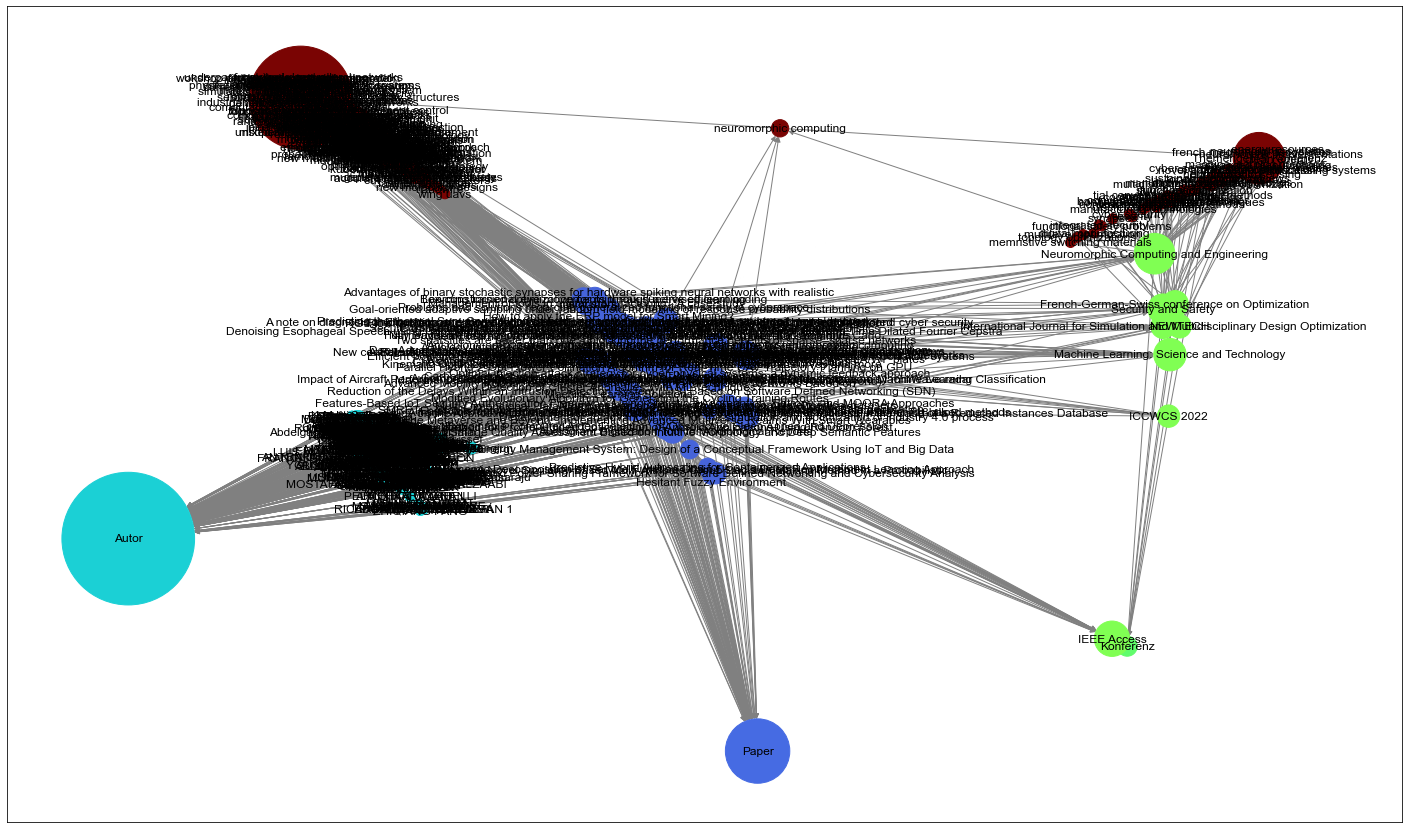

In [9]:
#Ausgabe Graph
def show_graph(G_KG,colors):
    plt.figure(figsize=(25,15))
    pos = nx.spring_layout(G_KG, k=10/math.sqrt(G_KG.order())) # Layout Graph
    d = dict(G_KG.degree)
    nx.draw_networkx(G_KG, with_labels=True, pos=pos, node_size=[v * 50 for v in d.values()], node_color=colors, edge_color= 'grey', font_family = 'Arial')
    #plt.show()
    plt.savefig("G_KG.png", format="PNG")